# Lab 4                           

Sanae Ohtomo

Here we have a data file containing the number of particles detected every 100 milliseconds collected by a gamma-ray satellite orbiting in low Earth orbit. In addition to number of particles, the file contains information regarding time the data was collected (in GPS seconds) , Solar phase (in deg) and Earth longitude (in deg). The purpose of collecting this data is to look for gamma-ray burstss, but quite often all we see in these data is the background cosmic rays. 

We will investigate the data to find unique features of these data.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [4]:
# importing the data file
hf = h5py.File('gammaray_lab4.h5', 'r')
hf.keys();
data = np.array(hf.get('data'))
data[:,0];
hf.close()

In [5]:
# The data file is very large so make a smaller subset of data to study the information
start = 0
n = 500000
sub_data_time = data[0,start:n]
sub_data_solar_phase = data[1,start:n]
sub_data_longitude  = data[2,start:n]
sub_data_part_count = data[3,start:n]

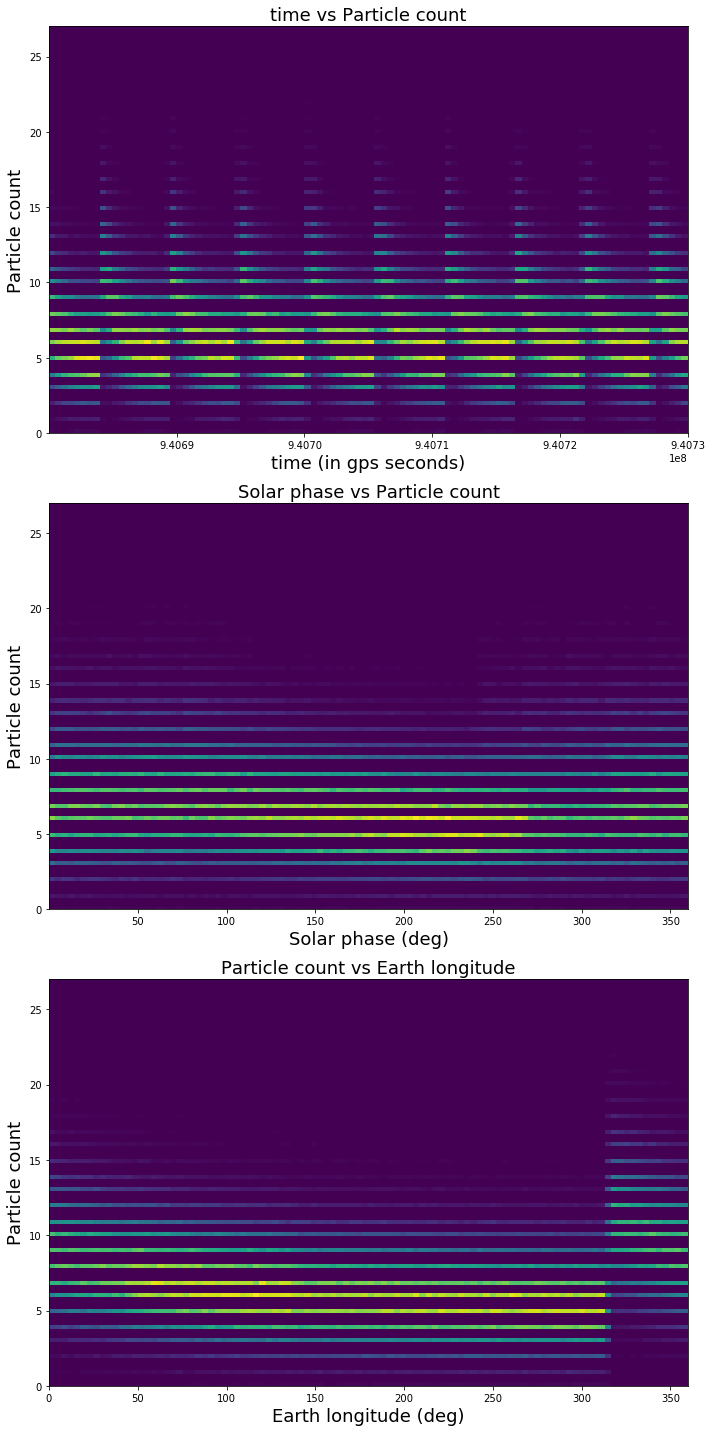

In [6]:
# plot a 2D histogram 
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,20))
axes[0].hist2d(sub_data_time,sub_data_part_count, bins = 100)
axes[0].set_xlabel('time (in gps seconds)', fontsize=18)
axes[0].set_ylabel('Particle count', fontsize=18)
axes[0].set_title("time vs Particle count", fontsize=18);

axes[1].hist2d(sub_data_solar_phase,sub_data_part_count, bins = 100)
axes[1].set_xlabel('Solar phase (deg)', fontsize=18)
axes[1].set_ylabel('Particle count', fontsize=18)
axes[1].set_title("Solar phase vs Particle count", fontsize=18);

axes[2].hist2d(sub_data_longitude,sub_data_part_count, bins = 100)
axes[2].set_xlabel('Earth longitude (deg)', fontsize=18)
axes[2].set_ylabel('Particle count', fontsize=18)
axes[2].set_title("Particle count vs Earth longitude", fontsize=18);

fig.tight_layout()

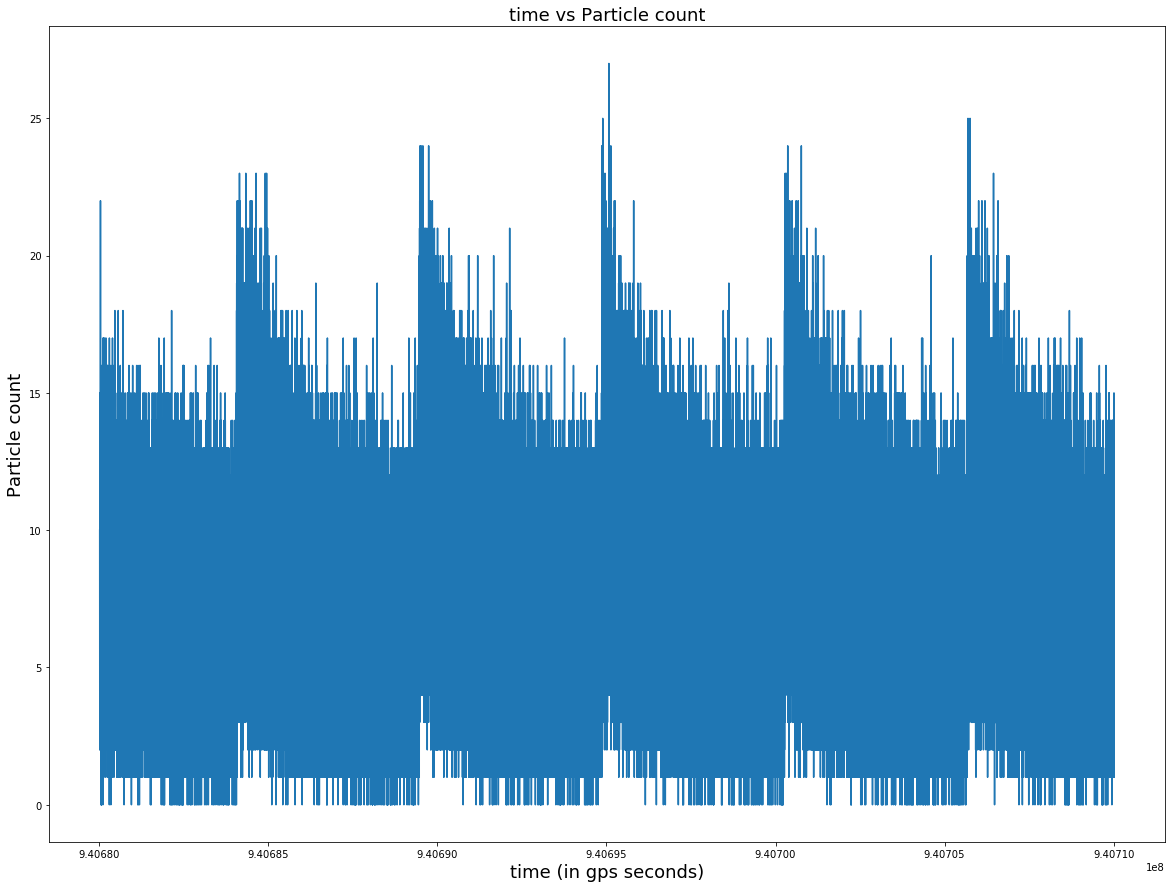

In [7]:
# Creating a scatter plots to see the data from a different point
n = 300000
sub_data_time = data[0,start:n]
sub_data_part_count = data[3,start:n]
plt.plot(sub_data_time,sub_data_part_count);
plt.xlabel('time (in gps seconds)', fontsize=18)
plt.ylabel('Particle count', fontsize=18)
plt.title("time vs Particle count", fontsize=18);

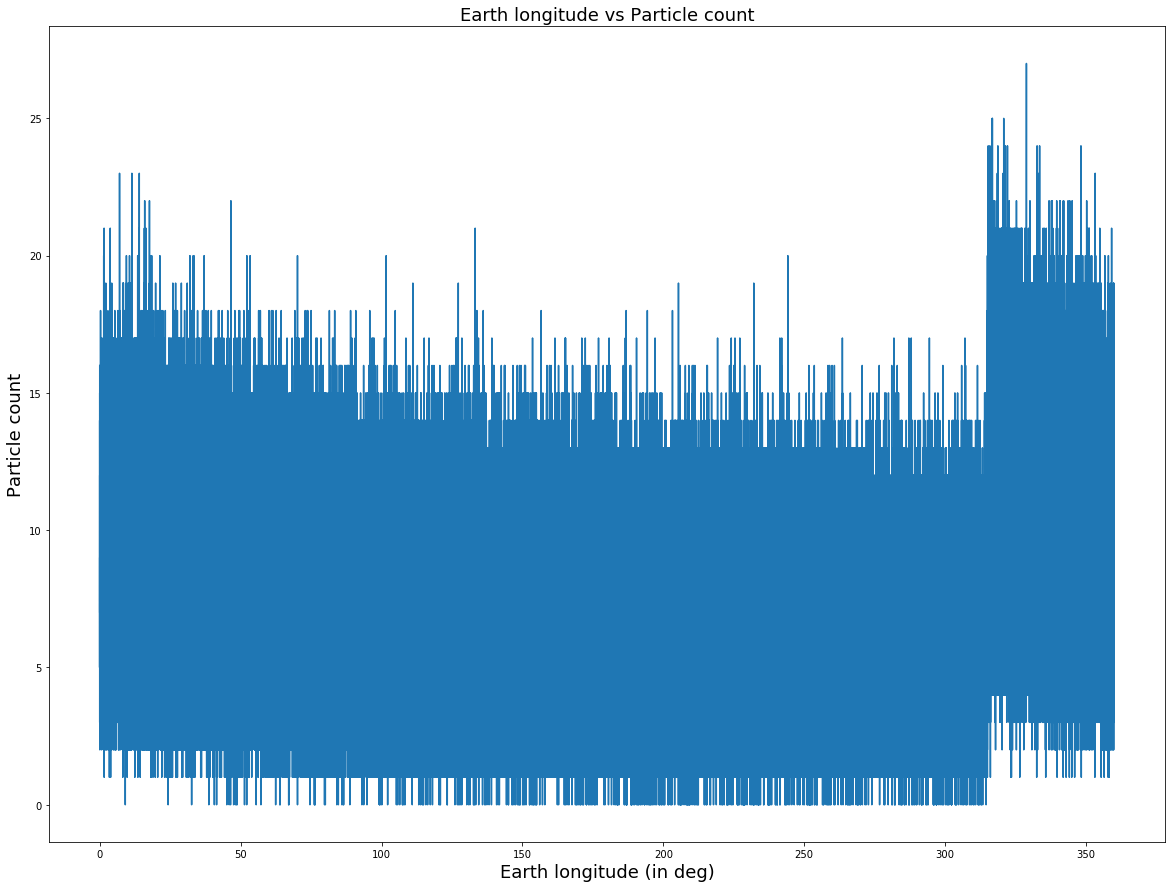

In [8]:
# Creating a scatter plots to see the data from a different point
n = 300000
start = 0
sub_data_longitude  = data[2,start:n]
sub_data_part_count = data[3,start:n]

plt.plot(sub_data_longitude,sub_data_part_count);


plt.xlabel('Earth longitude (in deg)', fontsize=18)
plt.ylabel('Particle count', fontsize=18)
plt.title("Earth longitude vs Particle count", fontsize=18);

I've used a 2D histogram to see if there is any correlation between particle counts and the other parameters. We can clearly see a periodic behavior in the 2D histogram and this behavior is even more clear in the scatter plot. If you look at it closely you can also see that there is a relationship between particle counts and the earth longitude. They both exhibit a cyclical behavior. As you can see, this cyclical behavior is very consistent throughout the whole data set for time vs particle count plot and earth longitude vs particle count. For each period, the average number of the particle count showed a similar trend of starting at a value about 10 and slowly decreasing to a value around 6 at the end of the cycle. Considering this trend is repeated consistently through out the whole data set, we can say that background varies in time.



From the plots we previously created, we can see that particle counts depends on time and earth longitude and it has a cyclical behavior. Within each cycle, there is a different mean value for each x value and this can be descrbed by a poisson distribution having a specific average value. However, there is an additional feature to this cyclical behavior which is that the mean value at the beginning of the period is the highest mean value and it continues to decrease over the period. This can by described by an exponential decay. So our distribution should have these characteristics.

In [9]:
# To find the number of cycles in the data, find the total time, duration of each period and number of cycles
start_time = np.min(data[0,0])
end_time = np.max(data[0,25920001-1])
duration_second = end_time - start_time
duration_minute = duration_second/60
duration_hours = duration_second/60/60
duration_days = duration_hours/24
period = 90*60
num_period = duration_second/period

print('Start time = {:.6f}'.format(start_time))
print('Start time = {:.0f}'.format(end_time))
print('Duration in gps seconds = {:.0f} seconds'.format(duration_second))
print('Duration converted in minutes = {:.0f} minutes'.format(duration_minute))
print('Duration converted in hours = {:.0f} hours'.format(duration_hours))
print('Duration converted in hours = {:.0f} days'.format(duration_days))

print('Each period = {:.0f} seconds'.format(period))
print('Total number of period in this data = {:.0f} period'.format(num_period))

Start time = 940680016.000000
Start time = 943272016
Duration in gps seconds = 2592000 seconds
Duration converted in minutes = 43200 minutes
Duration converted in hours = 720 hours
Duration converted in hours = 30 days
Each period = 5400 seconds
Total number of period in this data = 480 period


In the following section, I will find how the mean particle count changes within one cycle. A set of data is divided into a small bin sizes and we will find a mean value for each bin. Once we go through all bins in this data set we can find the maximum mean value and minimum mean value. The maximum mean value indicates a start of the period and the minimum mean value indicates the end of the period. As you will see, the maximum mean value is 10.74 and the minimum value is 5.84.

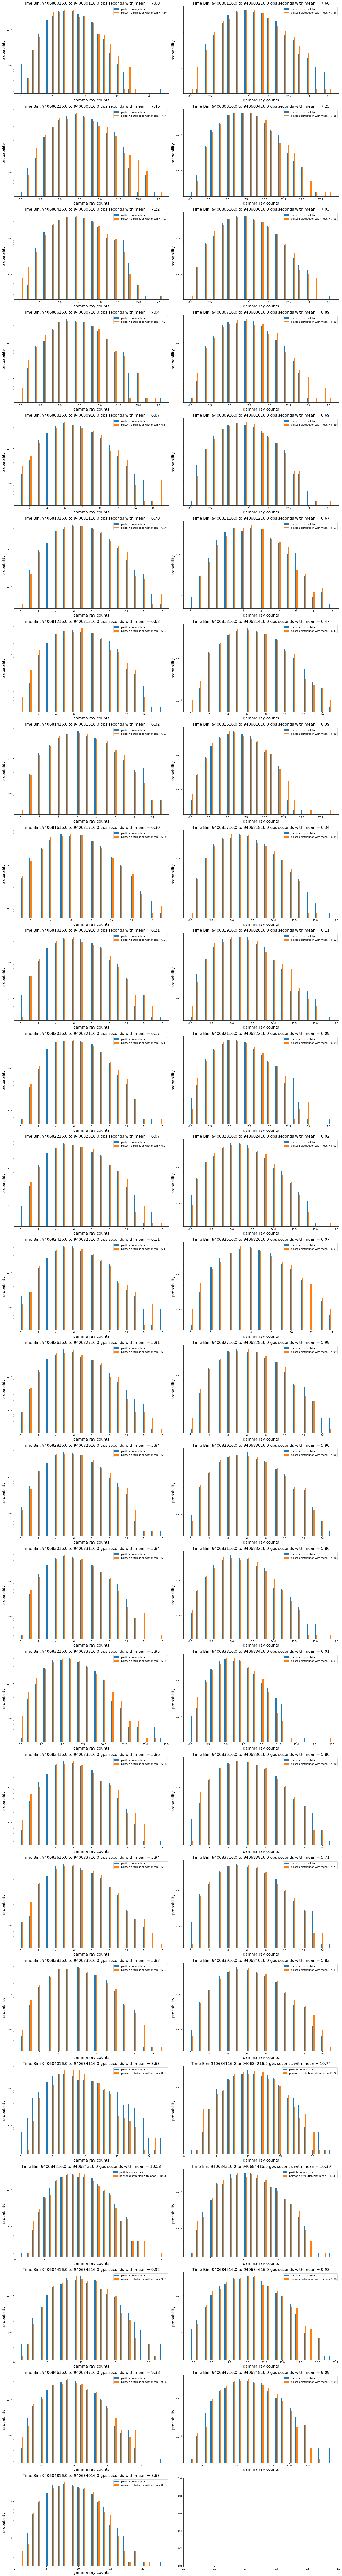

In [10]:
# define the sub data we are using for this part
n  = 50000
sub_time = sub_data_time[0:n]
sub_particleCounts = sub_data_part_count[0:n]

# define how many bins I want to divide the region above
binCounts = 50
binSize = int(sub_time.size / binCounts)

## divide the data into bins and plot the distribution in each bin out
# create subplots
fig, ax = plt.subplots(25, 2, figsize=(20, 150))
row = 0
col = 0

# create empty mean array to store mean for each bin
mean = np.empty(0)

# fill data into each plot
for i in range(binCounts-1): # the distribution in each bin fills a subplot
    # get time and gammarayCounts(x) for each bin
    timeLeft = sub_time[i*binSize]
    timeRight = sub_time[(i+1)*binSize]
    x = sub_particleCounts[i*binSize : (i+1)*binSize]
    
    # create a poisson distribution
    meanInBin = np.mean(sub_particleCounts[i*binSize : (i+1)*binSize])
    poissonPerBin = stats.poisson.rvs(mu = meanInBin, size = x.size)
    
    # append meanInBin to mean array
    mean = np.append(mean, meanInBin)
    
    # fill subplot
    ax[row,col].hist([x,poissonPerBin], bins = 50, density = True)
    ax[row,col].set_title("Time Bin: " + str(timeLeft) + " to " + str(timeRight) + " gps seconds with mean = %.2f" %meanInBin, fontsize = 16)
    ax[row,col].set_xlabel("gamma ray counts", fontsize = 16)
    ax[row,col].set_ylabel("probability", fontsize = 16)
    ax[row,col].legend(["particle counts data", "poisson distribution with mean = %.2f" %meanInBin])
    ax[row,col].set_yscale("log")
    
    plt.tight_layout()
    
    # move to the next sub plot
    if (col < 1) : # same row, filling the other columns in the same row
        row = row
        col = col + 1
    else : # this row is full, go to next row, start filling from column 0
        row = row + 1
        col = 0

The above plots give me a list of variable particle counts at different time. Another thing we can see in these plot is that the particle counts do not completely follow the Poisson distribution shape. From this we can say that there is some kind of signal contamination affecting the particle counts.

Now that we have a list of means within each period, we can plot these data to see how the means behave within each cycle.

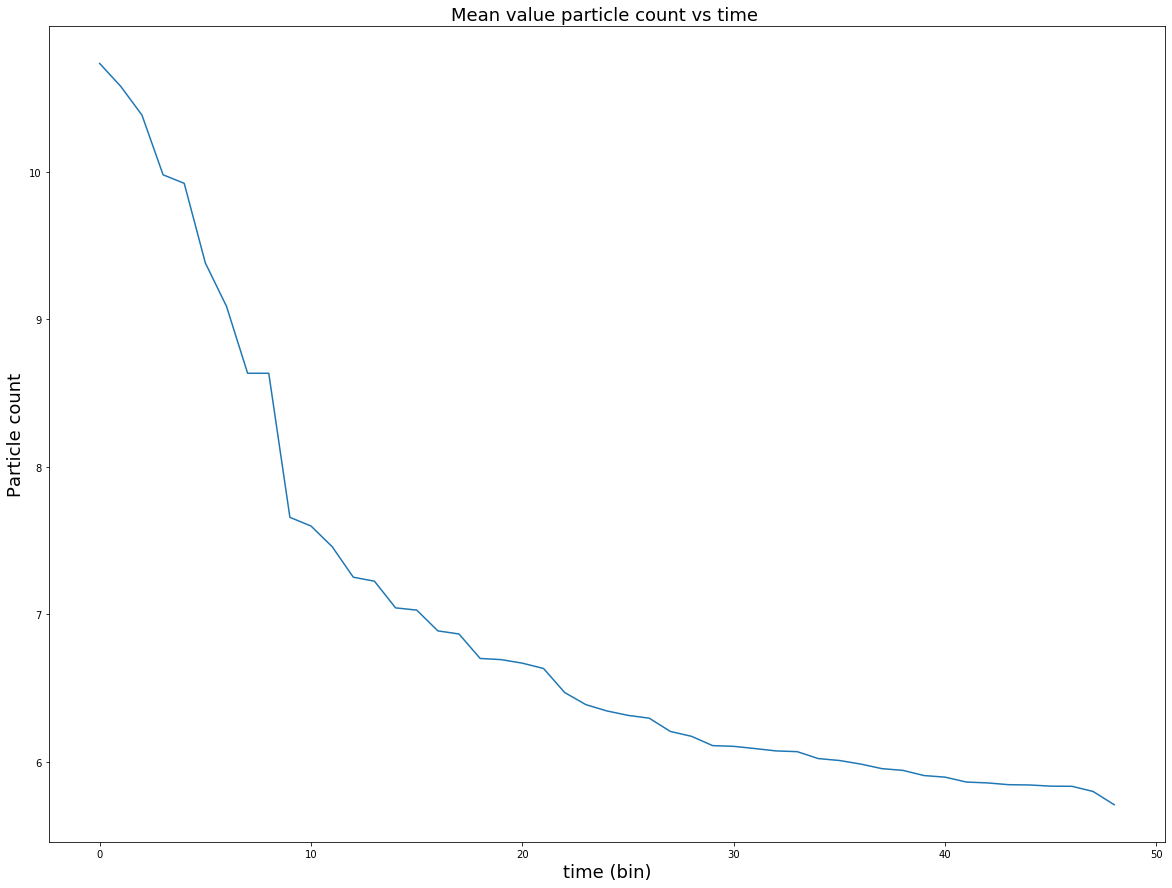

In [11]:
# plotting my mean values to see how they behave
sorted_mean = np.sort(mean)[::-1]
plt.plot(sorted_mean);

plt.xlabel('time (bin)', fontsize=18)
plt.ylabel('Particle count', fontsize=18)
plt.title("Mean value particle count vs time ", fontsize=18);

We can see in above plot that the means behave like an eponential decay. So using a curve fitting for an exponential decay, we can check to make sure we have what we think we see. And as you can see in the plot below, the curve seems to fit the data pretty well. So we can conclude that the means have an exponential decay pattern.

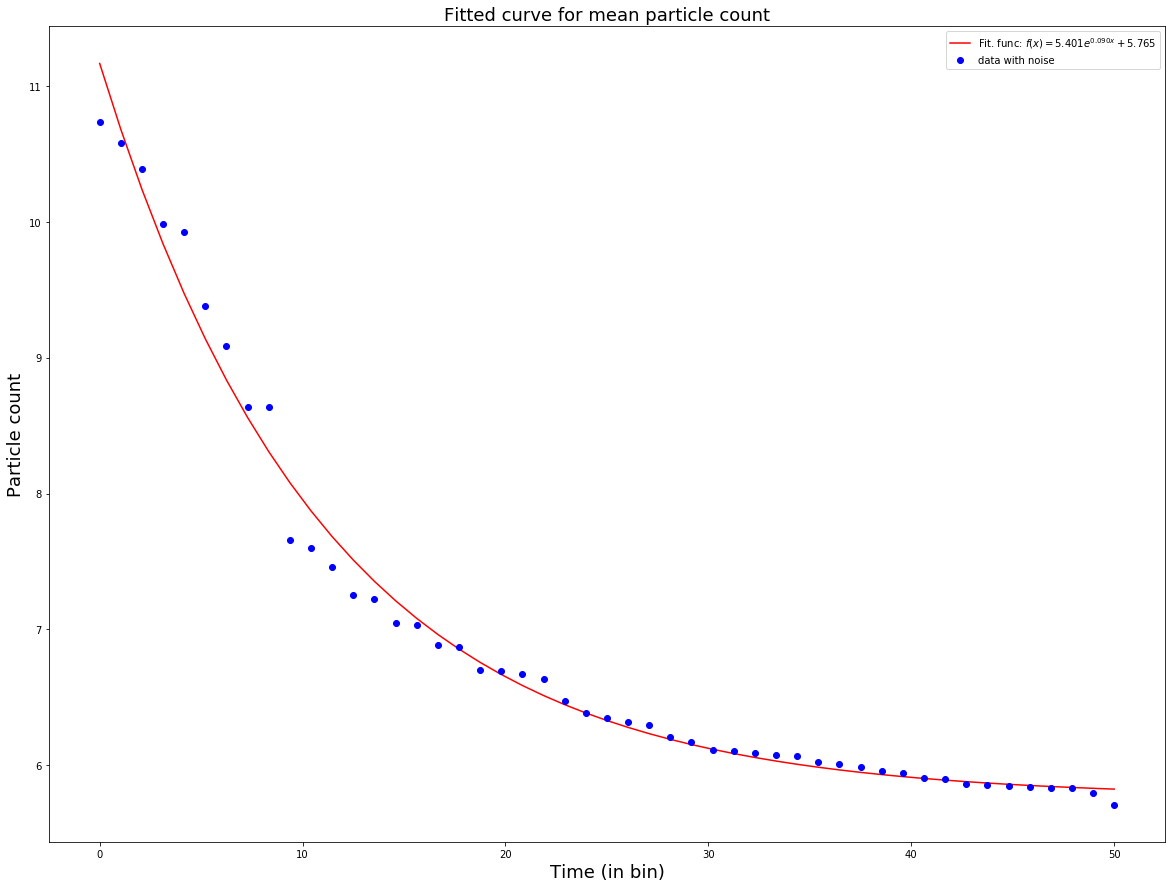

In [17]:

# fitting a curve to check it behaves like an exponential decay

from scipy.optimize import curve_fit
import numpy as np
# define type of function to search
def model_func(x, a, k, b):
    return a * np.exp(-k*x) + b

x = np.linspace(0, 50, num=49)
y = sorted_mean

# curve fit
p0 = (1.,1.e-5,1.) # starting search koefs
opt, pcov = curve_fit(model_func, x, y, p0)
a, k, b = opt
# test result
#x2 = np.linspace(250, 6000, 250)

x2 = x
y2 = model_func(x2, a, k, b)
fig, ax = plt.subplots()

ax.plot(x2, y2, color='r', label='Fit. func: $f(x) = %.3f e^{%.3f x} %+.3f$' % (a,k,b))
ax.plot(x, y, 'bo', label='data with noise')
ax.set_xlabel('Time (in bin)', fontsize=18)
ax.set_ylabel('Particle count', fontsize=18)
ax.set_title("Fitted curve for mean particle count", fontsize=18);
ax.legend(loc='best')
plt.show();


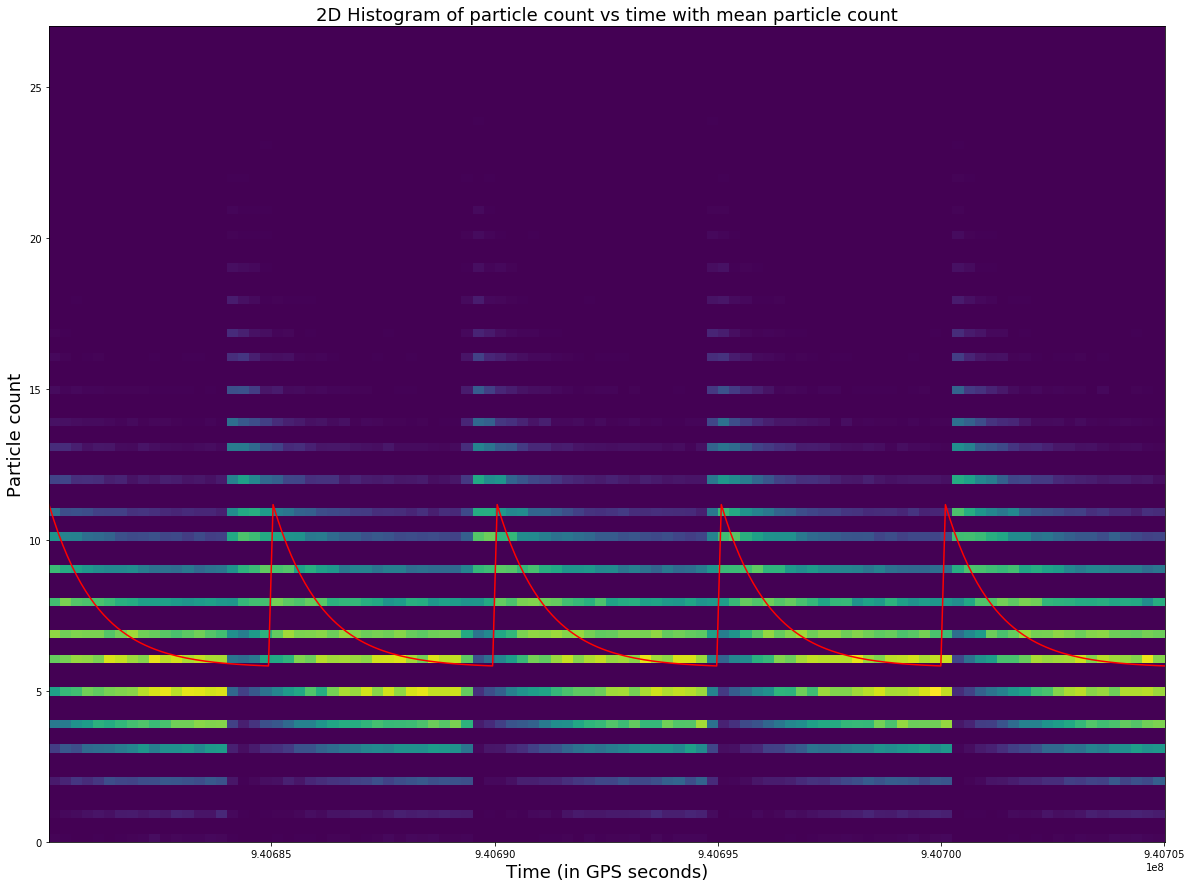

In [19]:
# Here I am plotting a 2D histogram of the first 5 period from the original data and my model curve

test = np.zeros(0,dtype=int)
for i in range(0,5):
    test = np.append(test, y2)

x = np.linspace(sub_data_time[0],sub_data_time[250000], test.size)
plt.hist2d(sub_data_time[0:250000],sub_data_part_count[0:250000], bins = 100)
plt.plot(x,test,color='r');
plt.xlabel('Time (in GPS seconds)', fontsize=18)
plt.ylabel('Particle count', fontsize=18)
plt.title("2D Histogram of particle count vs time with mean particle count", fontsize=18);

Although the fitted curve and the 2d histogram do not match up perfectly, it shows that the exponential decay is a good fit to model this periodic pattern. The reasons why they are not matching perfectly is because 1) The curve is based on a best fit on the means so the numbers do not quite overlap with the actual data, and 2) each period is not precisely 90 minutes.

4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?



In [159]:
print()
start_time = np.min(data[0,0])
end_time = np.max(data[0,25920001-1])
sec_per_period = (end_time - start_time) / 480

# folding the time for each period
time = data[0,500] # Here I am giving a random value of time in GPS seconds from the data file
t_fold = time % (start_time + sec_per_period)
bin_size = sec_per_period/49

start = start_time


# based on the time, find the location in the array which will give the correct mu for the poisson distribution
for i in range(0,49):
    start = start + bin_size
    if t_fold < start:
        bin_num = i
        break
    

#This is the mu value for the poisson distribution
mu = sorted_mean[i] 
prob = stats.norm.cdf(5)
sigma = stats.poisson.ppf(prob, mu)

print('The mu value for the poisson distribution = {:.4f}'.format(mu))
print('The 5sigma threshold is = {:.0f}'.format(sigma) +' particle count or greater at ' + str(time) +' GPS seconds' )
print()


The mu value for the poisson distribution = 10.7360
The 5sigma threshold is = 31 particle count or greater at 940680066.0 GPS seconds



In [163]:
print()
start_time = np.min(data[0,0])
end_time = np.max(data[0,25920001-1])
sec_per_period = (end_time - start_time) / 480

# folding the time for each period
time = data[0,10244] # Here I am giving a random value of time in GPS seconds from the data file
t_fold = time % (start_time + sec_per_period)
bin_size = sec_per_period/49

start = start_time


# based on the time, find the location in the array which will give the correct mu for the poisson distribution
for i in range(0,49):
    start = start + bin_size
    if t_fold < start:
        bin_num = i
        break
    

#This is the mu value for the poisson distribution
mu = sorted_mean[i] 
prob = stats.norm.cdf(5)
sigma = stats.poisson.ppf(prob, mu)

print('The mu value for the poisson distribution = {:.4f}'.format(mu))
print('The 5sigma threshold is = {:.0f}'.format(sigma) +' particle count or greater at ' + str(time) +' GPS seconds' )
print()


The mu value for the poisson distribution = 7.6580
The 5sigma threshold is = 25 particle count or greater at 940681040.4 GPS seconds



As you can see, using the model we found in the previous section, we can calculate the 5 sigma threshold at that specific time in GPS seconds

# Problem 2



We have 10 images of the sky which containes the measured brightness of the stars and additional noise resulting from the experimental setup. Using these images we want to hunt for a possible super nova and the faintest signal of brightness that will gurantee us a star. 

In [20]:
hf = h5py.File('images.h5', 'r')
hf.keys()


<KeysViewHDF5 ['image1', 'imagestack']>

In [21]:
imagestack = np.array(hf.get('imagestack'))
hf.close()


- Below, I plotted out all 10 images to see if there is anything I could detect with my eyes. If there is something like a supernova in the image I thought I might be able to see it in the picture but it was not possible.

- Then I subtracted one image from the other to get a difference in these two images. 
  I decided to subtract all other images from image 1. This way  the difference in data is more clear once you compare the difference images and we will not lose much data in the process. The alternative would have been to subtract image 2 from image 1 and image 4 from image 3 and so on but we will have less difference images at the end.

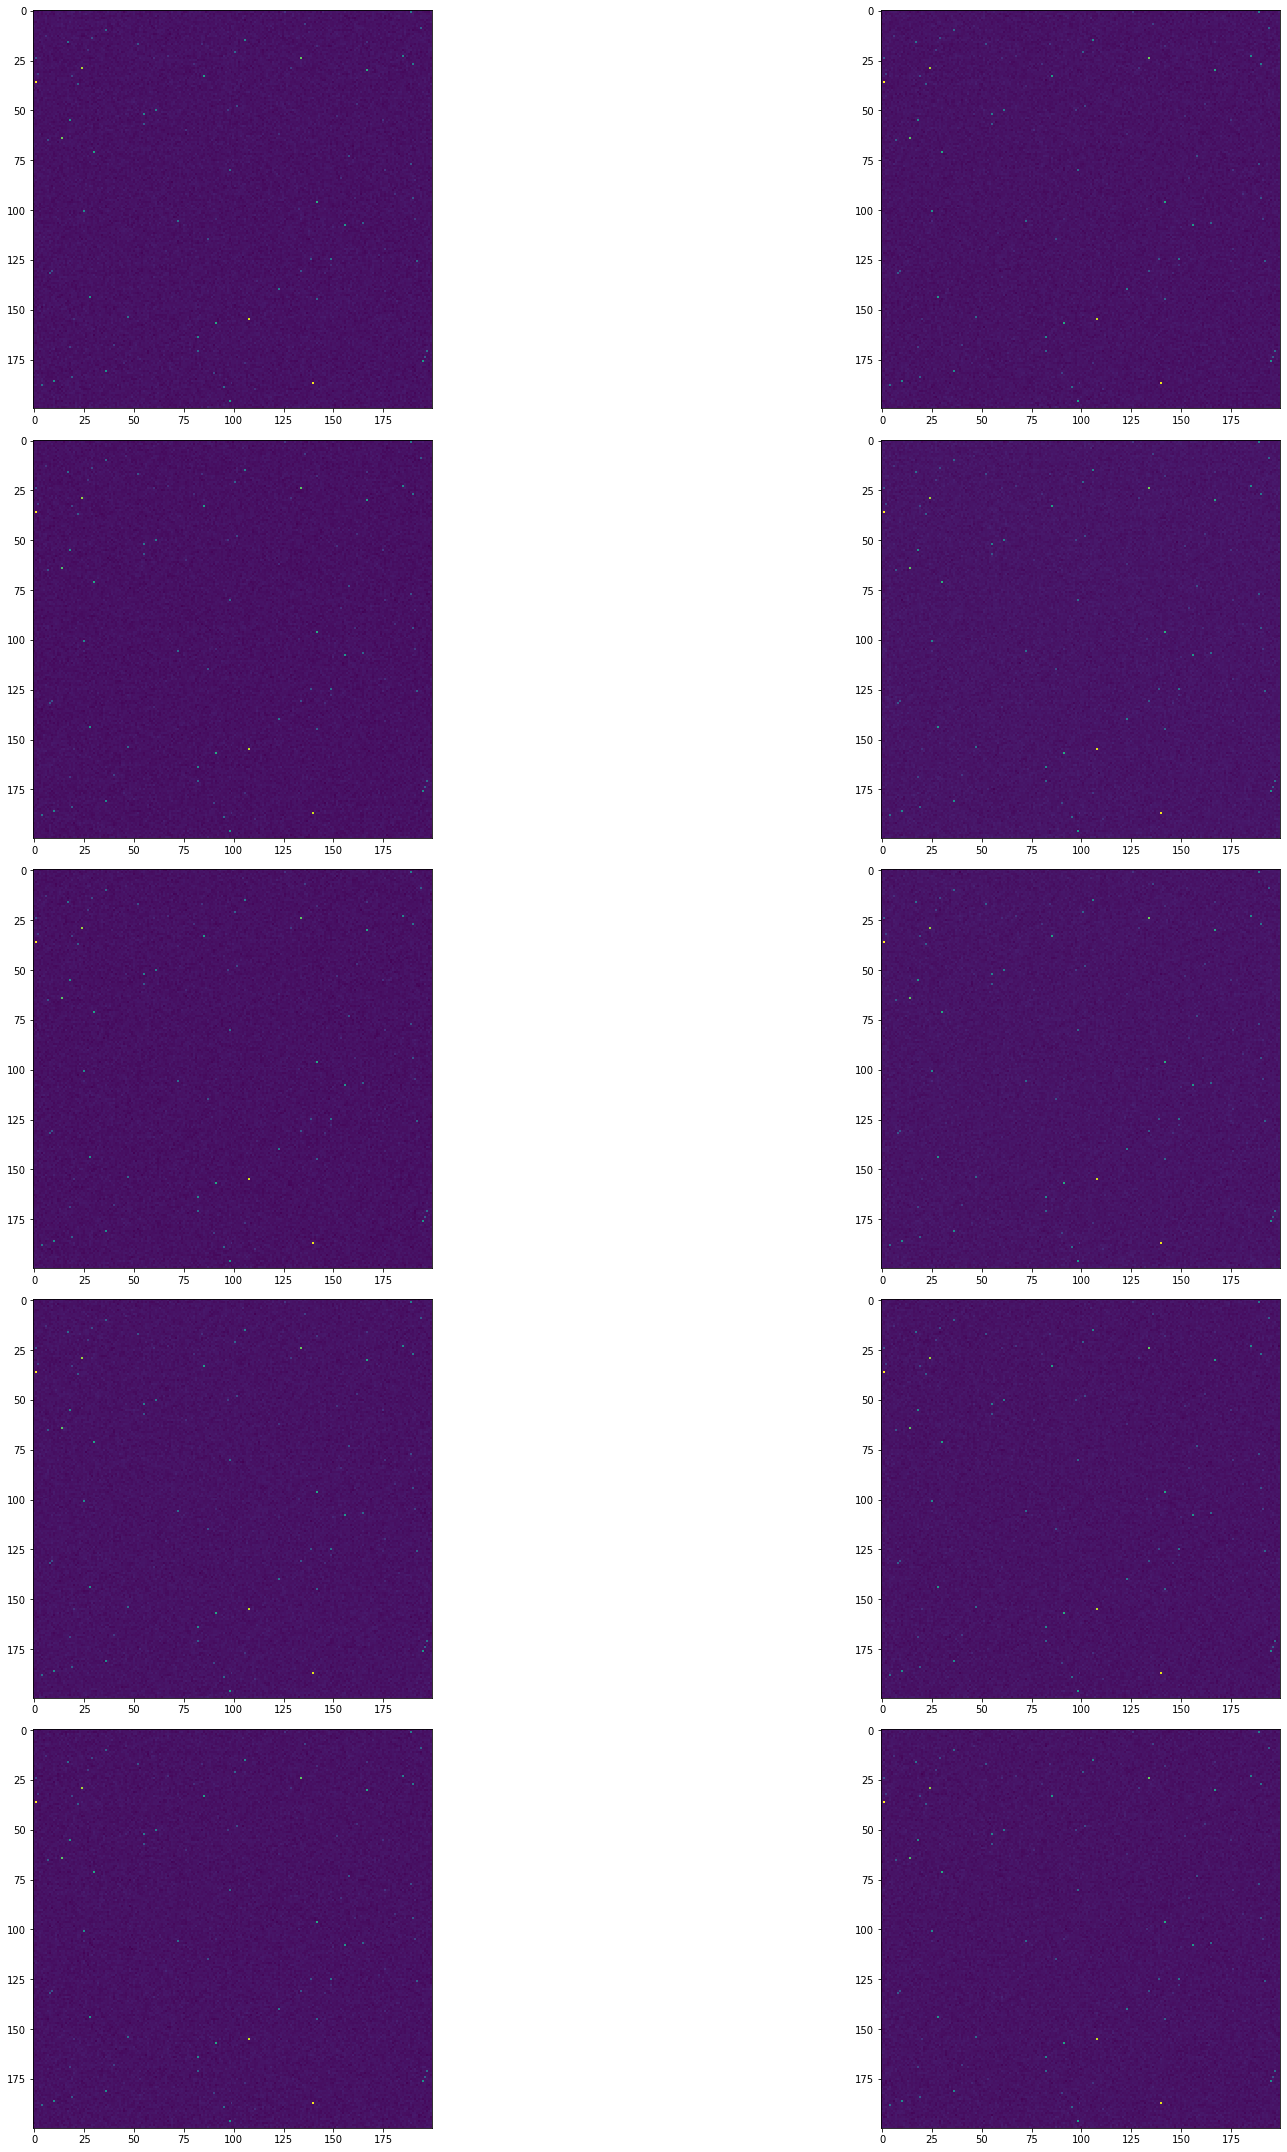

In [22]:
from PIL import Image

# in the array the x value = brighness, y value = signal brightness
#weighted_signal_brightness =

image1 = imagestack[:,:,0]
image2 = imagestack[:,:,1]
image3 = imagestack[:,:,2]
image4 = imagestack[:,:,3]
image5 = imagestack[:,:,4]
image6 = imagestack[:,:,5]
image7 = imagestack[:,:,6]
image8 = imagestack[:,:,7]
image9 = imagestack[:,:,8]
image10 = imagestack[:,:,9]
sum_images =  image1 + image2 + image3 + image4 + image5 + image6 + image7 + image8 + image9 + image10
ave_images = sum_images/10


fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(30, 30))
axes[0,0].imshow(image1)
axes[0,1].imshow(image2)
axes[1,0].imshow(image3)
axes[1,1].imshow(image4)
axes[2,0].imshow(image5)
axes[2,1].imshow(image6)
axes[3,0].imshow(image7)
axes[3,1].imshow(image8)
axes[4,0].imshow(image9)
axes[4,1].imshow(image10)
fig.tight_layout()

- Since it was not possible to detect anything with my naked eyes, I decided to plot an image of the difference in two images. I could create another image which is the average of the 10 images but this will also add more background data to each pixels so i decided to use the original image to take the difference.

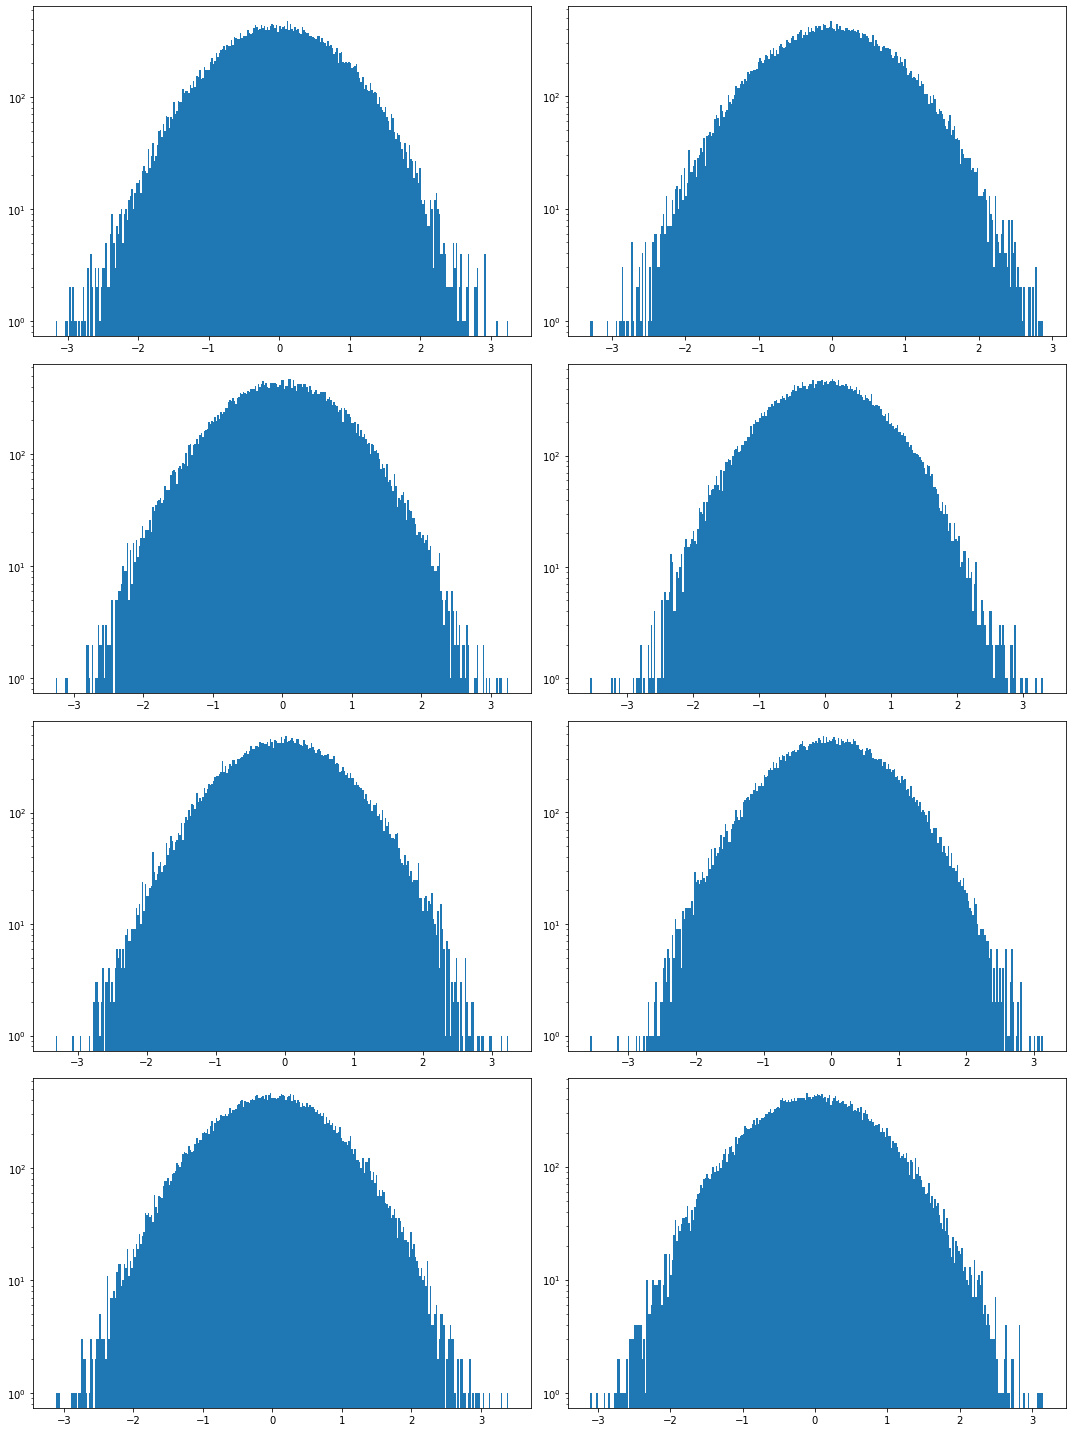

In [23]:
image_dff_12 = image1 - image2
image_dff_13 = image1 - image3
image_dff_14 = image1 - image4
image_dff_15 = image1 - image5
image_dff_16 = image1 - image6
image_dff_17 = image1 - image7
image_dff_18 = image1 - image8
image_dff_19 = image1 - image9
image_dff_110 = image1 - image10

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

axes[0,0].hist(np.ravel(image_dff_12), bins = 300)
axes[0,0].set_yscale('log')
axes[0,1].hist(np.ravel(image_dff_13), bins = 300)
axes[0,1].set_yscale('log')
axes[1,0].hist(np.ravel(image_dff_14), bins = 300)
axes[1,0].set_yscale('log')
axes[1,1].hist(np.ravel(image_dff_15), bins = 300)
axes[1,1].set_yscale('log')
axes[2,0].hist(np.ravel(image_dff_16), bins = 300)
axes[2,0].set_yscale('log')
axes[2,1].hist(np.ravel(image_dff_17), bins = 300)
axes[2,1].set_yscale('log')
axes[3,0].hist(np.ravel(image_dff_18), bins = 300)
axes[3,0].set_yscale('log')
axes[3,1].hist(np.ravel(image_dff_19), bins = 300)
axes[3,1].set_yscale('log')
fig.tight_layout()

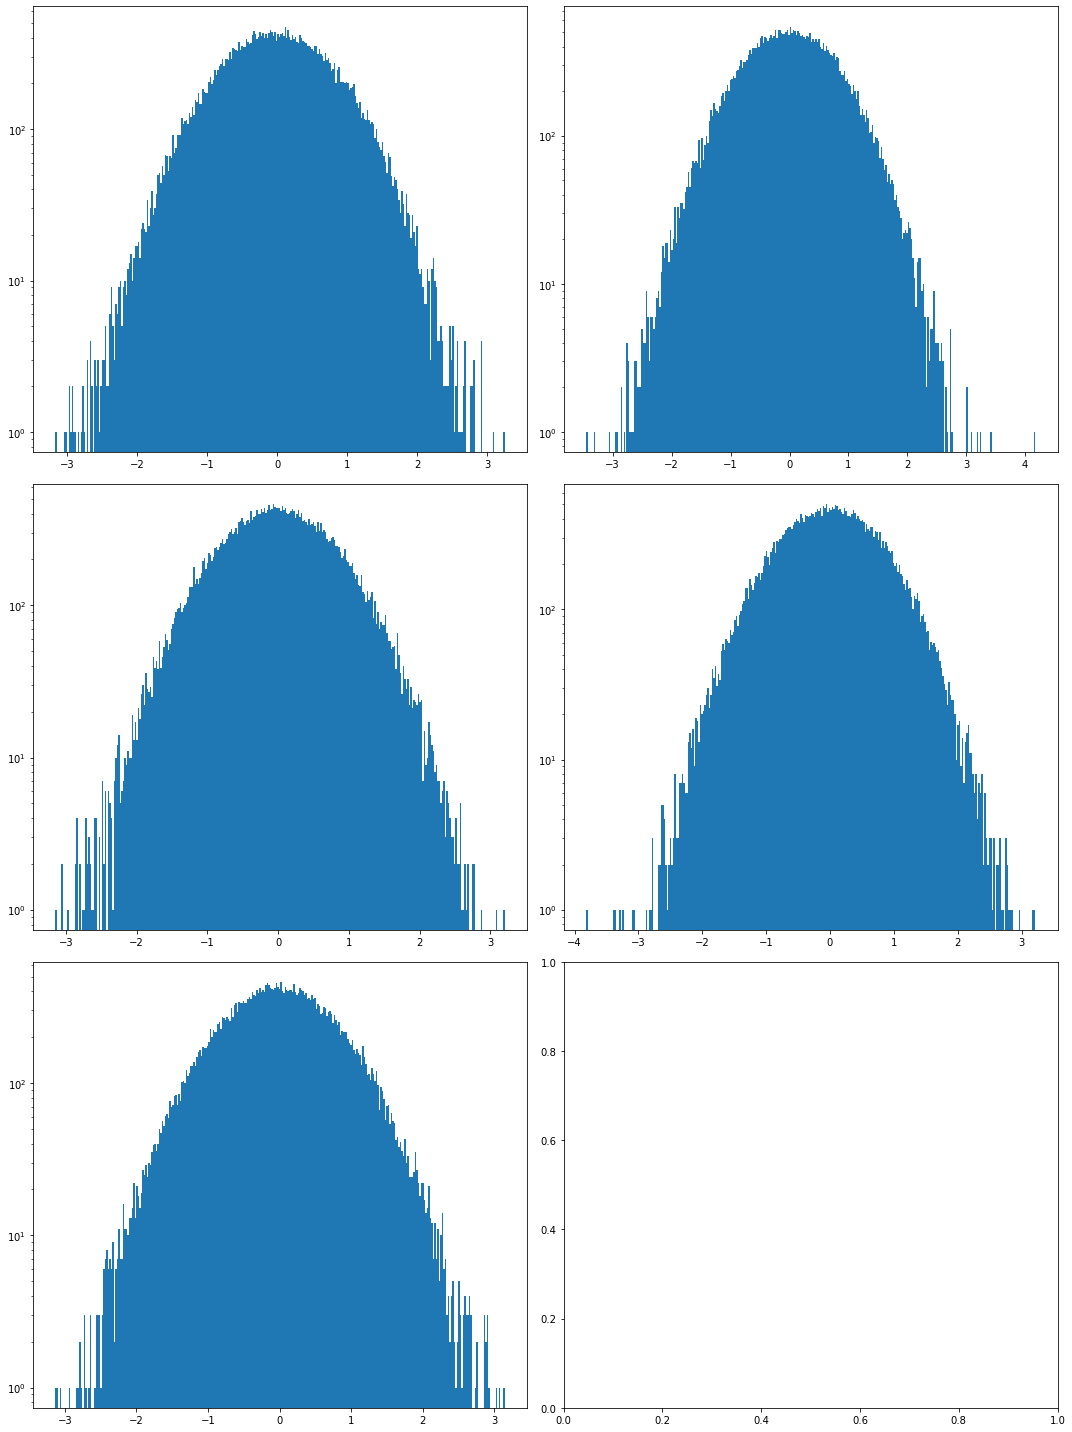

In [24]:
image_dff_12 = image1 - image2
image_dff_34 = image3 - image4
image_dff_56 = image5 - image6
image_dff_78 = image7 - image8
image_dff_910 = image9 - image10


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
axes[0,0].hist(np.ravel(image_dff_12), bins = 300)
axes[0,0].set_yscale('log')
axes[0,1].hist(np.ravel(image_dff_34), bins = 300)
axes[0,1].set_yscale('log')
axes[1,0].hist(np.ravel(image_dff_56), bins = 300)
axes[1,0].set_yscale('log')
axes[1,1].hist(np.ravel(image_dff_78), bins = 300)
axes[1,1].set_yscale('log')
axes[2,0].hist(np.ravel(image_dff_910), bins = 300)
axes[2,0].set_yscale('log')

fig.tight_layout()

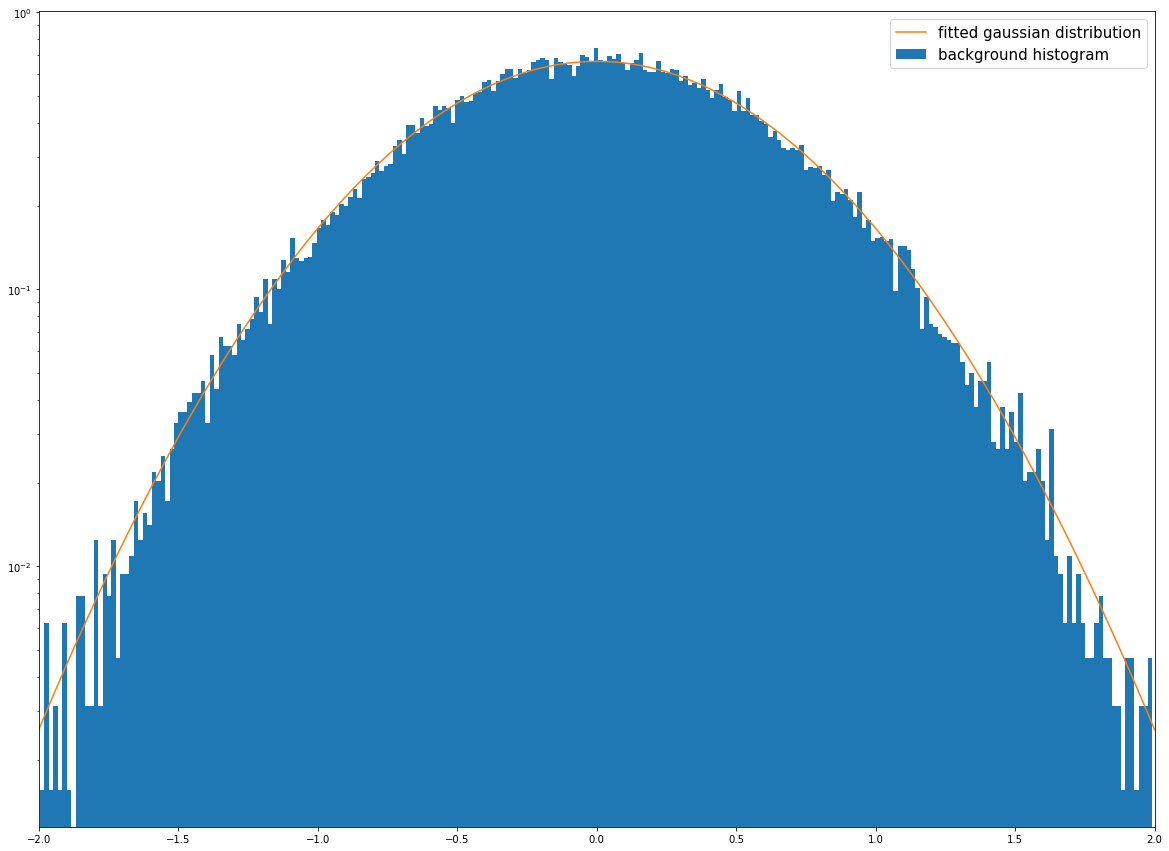

In [25]:
sum_image = image_dff_12 + image_dff_13 + image_dff_14 + image_dff_15 + image_dff_16+image_dff_17+image_dff_18+image_dff_19 + image_dff_110
ave_image = sum_image/9

plt.hist(np.ravel(ave_image), bins = 300, density = True, label='background histogram' );

x = np.linspace(-2, 2, ave_image.size)
plt.plot(x, stats.norm.pdf(x,loc = 0, scale = 0.6),label='fitted gaussian distribution')
plt.yscale('log')
plt.legend(fontsize=15)
plt.xlim([-2,2]);

Using the fitted line, I have a gaussian distribution that fits very well with the data distrubtion we have.I am confident to use this normal distribution with mean

In [26]:
prob = stats.norm.cdf(5)
sigma = stats.norm.ppf(prob, loc=0, scale=0.6)
print('The faintest star should have a measured brightness equal to = {:.4f}'.format(sigma))

The faintest star should have a measured brightness equal to = 3.0000


To find the faintest star, we could use the gaussian distribution we found by summing up all the differences in pictures and dividing it by the number of difference images. This way we are left with an image that approximately only contains the background noise.  Stars' measured brigtness are mostly coherent among all pictures, so when we take the difference in two pictures, the starts' brigtness get cancelled out and what remain in the difference image is the background noise and the transient star' measured brightness. After we sum up all these difference images and average it out, the transient star information gets reduced to a very insignicant value as well. This is because a transient star appears so infrequently in images, once we take the average the value of this brightness gets much smaller than the initially measured value. For this reason, we can say what we have is a data containing only the background noise. And using this data we can construct a background distribution to hunt for the faintest star. Because I am taking the average of the sum of all backgrounds in 10 images, I can treat this as a time independent background. And as you can see from the shape of each of the difference image, the background is spatically consistent.

However, this background distribution does not work for hunting for a transient star. First of all, a transient star can either be bright or dim. So comparing the measured brigtness relative to the background is not helpful in checking for a transient star. What we can do is to use the distribution we used to hunt for the faintest star and subtract this image from each original image. This way we have an image file only containing the starts' measured brightness. Once we add all these 10 images, we have amplified images of permanent stars. Again, permanent stars have coherent measured brightnes so all permanent stars will have 10 times its original measured brightness but the rare super nova will retain it's original brightness. Since the value of the super nova will be very small relative to the brightness of the permanent stars and there will only be very little amount of super nova relative to permanent stars we can consider this to be a data file for permanent stars only. Using this and creating a distribution for the permanent stars, we can look for the 5 sigma signal to the  left of the mean we can look for a possible transient star.